In [45]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from fredapi import Fred
import quandl

import os

from scipy.stats.mstats import gmean

%matplotlib inline

In [2]:
#set quandl api key
qd = os.environ.get('QUANDL_API_KEY')
quandl.api_config.ApiConfig.api_key = qd

In [3]:
# Set the start and end dates
start_d = datetime.datetime(1978, 1, 1)
end_d = datetime.datetime(2019, 12, 31)

## Get the historical closing levels of the return varialbes

In [4]:
spx = web.DataReader('^GSPC', 'yahoo', start_d, end_d).dropna()

In [5]:
spx.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1978-01-03,95.150002,93.489998,95.099998,93.820000,17720000,93.820000
1978-01-04,94.099998,92.570000,93.820000,93.519997,24090000,93.519997
1978-01-05,94.529999,92.510002,93.519997,92.739998,23570000,92.739998
1978-01-06,92.660004,91.050003,92.660004,91.620003,26150000,91.620003
1978-01-09,91.480003,89.970001,91.480003,90.639999,27990000,90.639999


In [6]:
fred = Fred()

In [7]:
y10 = fred.get_series('DGS10',start_d,end_d).dropna()
y10.name = '10y Yield'

In [8]:
closes = spx[['Adj Close']].join(y10,how='inner')
closes.rename(columns={'Adj Close':'SPX Price'},inplace=True)

In [9]:
closes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10486 entries, 1978-01-03 to 2019-12-31
Data columns (total 2 columns):
SPX Price    10486 non-null float64
10y Yield    10486 non-null float64
dtypes: float64(2)
memory usage: 245.8 KB


In [10]:
closes.describe()

,SPX Price,10y Yield
count,10486.000000,10486.000000
mean,958.014088,6.166427
std,751.438577,3.291189
min,86.900002,1.370000
25%,288.384987,3.490000
50%,923.739990,5.710000
75%,1352.039948,8.340000
max,3240.020020,15.840000


## Convert the closing levels into daily cash return percentages

Easy for stocks, more difficult for bonds

We will assume bond is purchased at Par at the start of each period.

Bond Return = Return from yield change + accrued interest

In [11]:
returns = pd.DataFrame()

In [12]:
returns['Stock_Returns'] = closes['SPX Price'].pct_change().dropna()

In [13]:
def bond_price(par,T,ytm,coup,freq=2):
    per = T*freq
    price = ((1-(1+ytm/freq)**(-per))/(ytm/freq))*(coup/freq) + par*(1+ytm/freq)**(-per)
    return price

In [14]:
print(bond_price(1,10,.0199,.02))
print(bond_price(1,10,.02,.02))
print(bond_price(1,9.75,.02,.02))

1.0009027320480295
1.0
1.0


In [15]:
calc = closes[['10y Yield']]

In [16]:
calc['t']=(closes.index.to_series().diff().dt.days/365)

In [17]:
calc['Prev']=calc['10y Yield'].shift(1)

In [18]:
calc['Return']= calc.apply(lambda x: bond_price(1,10,x['10y Yield']/100,x['Prev']/100) - 1 + x['t']*x['Prev']/100,axis=1)

In [19]:
calc.dropna(inplace=True)

In [20]:
calc.tail(12)

,10y Yield,t,Prev,Return
2019-12-13,1.82,0.002740,1.90,0.007336
2019-12-16,1.89,0.008219,1.82,-0.006201
2019-12-17,1.89,0.002740,1.89,0.000052
2019-12-18,1.92,0.002740,1.89,-0.002666
2019-12-19,1.92,0.002740,1.92,0.000053
2019-12-20,1.92,0.002740,1.92,0.000053
2019-12-23,1.93,0.008219,1.92,-0.000748
2019-12-24,1.90,0.002740,1.93,0.002773
2019-12-26,1.90,0.005479,1.90,0.000104
2019-12-27,1.88,0.002740,1.90,0.001868


In [21]:
# Returns make sense, small positive for days with no yield change and yield higher = negative returns

In [22]:
response = pd.DataFrame()

In [23]:
response['Stock_Returns']=closes['SPX Price'].pct_change().dropna()
response['Bond_Returns'] = calc['Return']

In [24]:
response.describe()

,Stock_Returns,Bond_Returns
count,10485.000000,10485.000000
mean,0.000397,0.000300
std,0.010855,0.005076
min,-0.204669,-0.034687
25%,-0.004491,-0.002416
50%,0.000555,0.000229
75%,0.005584,0.002978
max,0.109862,0.048223


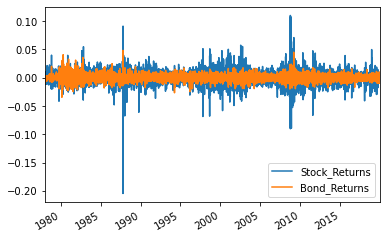

In [25]:
response.plot() 

In [26]:
def sharpe(returns, w1=.5, w2=.5, t_factor=252):
    '''Calculates annualized Sharpe for returns series.
    
    returns is an array of stock and bond daily % returns
    
    w1 = Stock Weight
    w2 = Bond Weight
    t_factor = time factor for annuization
    
    '''
    
    
    p_ret = np.dot(returns,np.array([w1,w2]))
    
    #s = ((gmean(p_ret+1)-1) / p_ret.std())*np.sqrt(t_factor) # using geometric mean
    
    s = (p_ret.mean()/p_ret.std())*np.sqrt(t_factor)
    
    return s

In [54]:
dt = '1/1/2017'
[(sharpe(response.loc[dt:,:],w,1-w),w) for w in np.arange(.05,.95,.05)]

[(0.9437631561152509, 0.05),
 (1.12746828689773, 0.1),
 (1.3111495939755793, 0.15000000000000002),
 (1.4709921379875266, 0.2),
 (1.5824180939353327, 0.25),
 (1.6334457596620917, 0.3),
 (1.630387394519837, 0.35000000000000003),
 (1.5905204184686645, 0.4),
 (1.531420645399349, 0.45),
 (1.4656202330104509, 0.5),
 (1.4003469658730636, 0.55),
 (1.3391136798335574, 0.6000000000000001),
 (1.283272778748416, 0.6500000000000001),
 (1.2330569100753093, 0.7000000000000001),
 (1.1881758180766318, 0.7500000000000001),
 (1.1481310594657226, 0.8),
 (1.1123720068964966, 0.8500000000000001),
 (1.0803679402635116, 0.9000000000000001)]

## Query features

In [28]:
#economic features

core_pce = fred.get_series('PCEPILFE',start_d,end_d).dropna()
core_pce=core_pce.pct_change().dropna()

nfp = fred.get_series('PAYEMS',start_d,end_d).dropna()
nfp = nfp.diff().dropna()

unemp = fred.get_series('UNRATE',start_d,end_d).dropna()

#excluding retail sales
#retail = fred.get_series('RSFSXMV',start_d,end_d).dropna()
#retail = retail.pct_change().dropna()

housing = fred.get_series('HOUST',start_d,end_d).dropna()

ip = fred.get_series('INDPRO',start_d,end_d).dropna()
ip = ip.pct_change().dropna()

ism = quandl.get("ISM/MAN_PMI",start_date=start_d, end_date=end_d)['PMI'].dropna() # Index to 50, above 50 = expanding comapred to prev month

umich_sent = fred.get_series('UMCSENT',start_d,end_d).dropna()

umich_inf = fred.get_series('MICH',start_d,end_d).dropna()

cpi = fred.get_series('CPILFESL',start_d,end_d).dropna()
cpi = cpi.pct_change().dropna()

economic_feat = {
    "Core_PCE":core_pce,
    "NFP": nfp,
    "UnEmp":unemp,
    "Hstarts":housing,
    "IP":ip,
    "ISM":ism,
    "Mich_Sent":umich_sent,
    "Mich_Inf":umich_inf,
    "CPI":cpi}

In [29]:
df_eco = pd.DataFrame(economic_feat).dropna()

In [41]:
df_eco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 1978-02-01 to 2019-12-01
Data columns (total 9 columns):
Core_PCE     503 non-null float64
NFP          503 non-null float64
UnEmp        503 non-null float64
Hstarts      503 non-null float64
IP           503 non-null float64
ISM          503 non-null float64
Mich_Sent    503 non-null float64
Mich_Inf     503 non-null float64
CPI          503 non-null float64
dtypes: float64(9)
memory usage: 59.3 KB


In [31]:
# Market Implied Features

bill3m = fred.get_series('TB3MS',start_d,end_d).dropna()

curve10y2y = fred.get_series('T10Y2Y',start_d,end_d).dropna()

y5 = fred.get_series('DGS5',start_d,end_d).dropna()
#y10 #calculated at top

In [32]:
#make sure index matches
(y5.index != y10.index).sum()

0

In [33]:
fwd5y5y = 2*y10 - y5

In [34]:
mkt_feat={
    "3M_Rate": bill3m,
    "10Y_2Y_Curve": curve10y2y,
    "5y5y_Forward": fwd5y5y
}

In [35]:
df_mkt = pd.DataFrame(mkt_feat)

In [36]:
df_mkt.resample('MS').mean()

,3M_Rate,10Y_2Y_Curve,5y5y_Forward
1978-01-01,6.44,0.470476,8.146190
1978-02-01,6.45,0.468333,8.234444
1978-03-01,6.29,0.460909,8.214091
1978-04-01,6.29,0.410500,8.325500
1978-05-01,6.41,0.339524,8.515714
...,...,...,...
2019-08-01,1.95,0.055000,1.765909
2019-09-01,1.89,0.051500,1.834000
2019-10-01,1.65,0.155455,1.888636
2019-11-01,1.54,0.199474,1.984737


In [37]:
#spot check
print(bill3m.loc['2019-10-1'])
print(curve10y2y.loc['2019-10'].mean())
print(fwd5y5y.loc['2019-10'].mean())



1.65
0.15545454545454543
1.888636363636364


In [38]:
#looks good
df_mkt=df_mkt.resample('MS').mean()

In [39]:
df_feat = df_mkt.join(df_eco)

In [40]:
df_feat

,3M_Rate,10Y_2Y_Curve,5y5y_Forward,Core_PCE,NFP,UnEmp,Hstarts,IP,ISM,Mich_Sent,Mich_Inf,CPI
1978-01-01,6.44,0.470476,8.146190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-02-01,6.45,0.468333,8.234444,0.003835,354.0,6.3,1738.0,0.004951,55.9,84.3,6.4,0.004754
1978-03-01,6.29,0.460909,8.214091,0.005407,512.0,6.3,2032.0,0.019062,55.0,78.8,6.3,0.006309
1978-04-01,6.29,0.410500,8.325500,0.006489,702.0,6.1,2197.0,0.020717,57.7,81.6,6.7,0.007837
1978-05-01,6.41,0.339524,8.515714,0.005866,347.0,6.0,2075.0,0.003709,60.2,82.9,6.9,0.006221
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,1.95,0.055000,1.765909,0.001332,207.0,3.7,1377.0,0.007050,48.8,89.8,2.7,0.002250
2019-09-01,1.89,0.051500,1.834000,0.000518,208.0,3.5,1274.0,-0.003476,48.2,93.2,2.8,0.001900
2019-10-01,1.65,0.155455,1.888636,0.001267,185.0,3.6,1340.0,-0.004070,48.5,95.5,2.5,0.001152
2019-11-01,1.54,0.199474,1.984737,0.000544,261.0,3.5,1371.0,0.009280,48.1,96.8,2.5,0.001940


In [42]:
df_feat.describe()

,3M_Rate,10Y_2Y_Curve,5y5y_Forward,Core_PCE,NFP,UnEmp,Hstarts,IP,ISM,Mich_Sent,Mich_Inf,CPI
count,504.000000,504.000000,504.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,4.442619,0.931684,6.603810,0.002390,134.003976,6.186879,1373.918489,0.001616,52.045924,86.316501,3.561034,0.002866
std,3.621002,0.929142,3.067483,0.001890,207.156041,1.648090,397.552506,0.006687,5.806009,12.649808,1.677907,0.002342
min,0.010000,-2.135714,1.765909,-0.005599,-800.000000,3.500000,478.000000,-0.043368,29.400000,51.700000,0.400000,-0.002469
25%,1.170000,0.223750,4.504762,0.001188,50.500000,5.000000,1112.000000,-0.001991,49.300000,76.500000,2.800000,0.001545
50%,4.555000,0.859012,5.874318,0.001893,175.000000,5.800000,1416.000000,0.002060,52.500000,90.000000,3.000000,0.002219
75%,6.442500,1.618182,8.539529,0.002991,264.500000,7.200000,1649.500000,0.005600,56.050000,95.100000,3.400000,0.003425
max,16.300000,2.834211,14.889524,0.009978,1118.000000,10.800000,2273.000000,0.020717,69.900000,112.000000,10.400000,0.014194


## DONE
 
df_feat contains all the features on a monthly basis

response contains the daily % returns of stocks and bonds

In [44]:
df_feat.to_csv("raw_features.csv")
response.to_csv("raw_response.csv")